# Extraction of Basic Features from PPG Signal

## Import packages

In [1]:
from utils.process_ppg import get_clean_segment, get_ppg_measures_batch
from scipy import signal
from datetime import datetime
%matplotlib inline

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import heartpy as hp
import pandas as pd
pd.set_option("display.precision", 2)
from scipy.interpolate import interp1d


# Load the data 
### Specify directory paths and the file containing PPG signal

In [2]:
basepath = os.path.join('data', 'EMPATICA_data') 
# Change this to analyze PPG singal of your interest
filepath = os.path.join(basepath, r'Empatica_A00FF7_ACC_PWC_17.csv')
sample_rate = 64  #Change this as per the sampling rate. 64 for Empatica E4 Wristband - though please verify this
dataframe = pd.read_csv(filepath, index_col='seconds')

In [3]:
time_array = np.array(dataframe.index, dtype=float)
time_array = (time_array - time_array[0])/1000.0
print(time_array[0:5])

[0.    0.031 0.063 0.094 0.125]


## Visualize raw signal

<AxesSubplot:xlabel='seconds'>

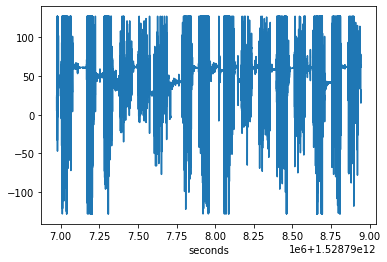

In [4]:
dataframe['ppg1'].plot()

<AxesSubplot:xlabel='seconds'>

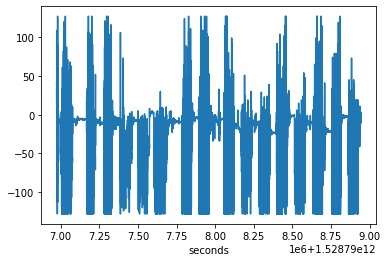

In [5]:
dataframe['ppg2'].plot()

<AxesSubplot:xlabel='seconds'>

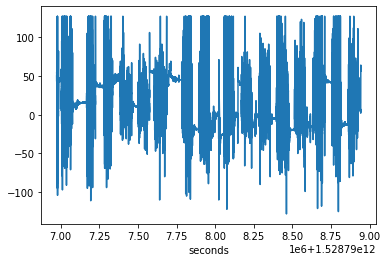

In [6]:
dataframe['gsr'].plot()

## Filter the signal and Plot


In [7]:
npy_ppg1 = np.array(dataframe['ppg1'], dtype=float)
# t_ppg1, ppg1_filtered = get_filtered_ppg(time_array, npy_ppg1, sample_rate=sample_rate)
sos = signal.butter(10, (1.0, 4.0), 'bandpass', fs=sample_rate, output='sos')
filtered = signal.sosfilt(sos, npy_ppg1)

Text(0.5, 1.0, 'Filtered PPG Signal')

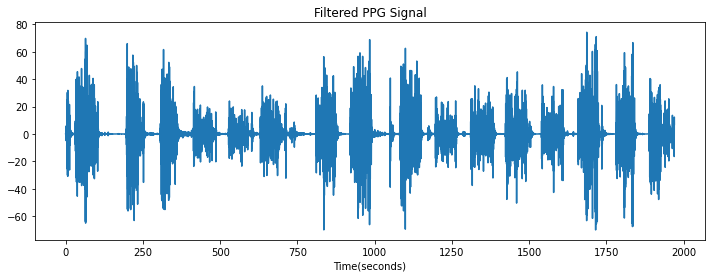

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(time_array, filtered)
plt.xlabel('Time(seconds)')
plt.title('Filtered PPG Signal')

Text(0.5, 1.0, 'Clean Segment of Filtered PPG Signal')

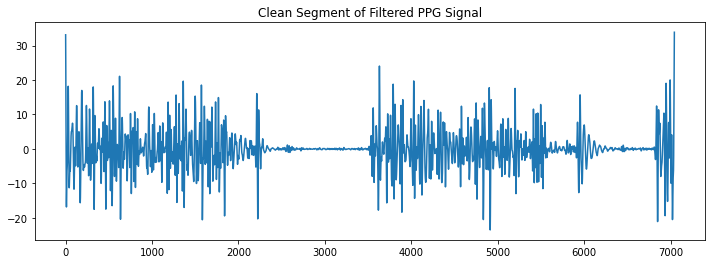

In [9]:
# This will try to get maximum clean segment available from the entire signal. With higher number for std_n, larger segment can be expected - though having more noise
filtered_clean = get_clean_segment(filtered, std_n=3.0)
plt.figure(figsize=(12, 4))
plt.plot(filtered_clean)
plt.title('Clean Segment of Filtered PPG Signal')


## Compute the features using 'heartpy' Python package <br>
Plot the signal with peaks identified and print the measures derived

In [10]:
wd, m = hp.process(filtered_clean, sample_rate=sample_rate)
print(wd.keys())

#display computed features
for measure in m.keys():
    print(measure, m[measure])

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])
bpm 102.44710211591537
ibi 585.6681034482758
sdnn 142.41678709176466
sdsd 127.34236256105656
rmssd 201.5691935853085
pnn20 0.9210526315789473
pnn50 0.7894736842105263
hr_mad 93.75
sd1 142.52975744175606
sd2 133.33531710204764
s 59703.61345924867
sd1/sd2 1.0689572765831539
breathingrate 0.26666666666666666


### Plot PPG signal with detected and rejected peaks

Text(0.5, 1.0, 'Filtered PPG Signal with Detected Peaks: ')

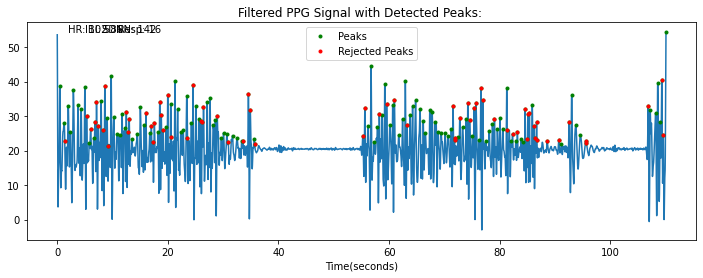

In [11]:
#Plot PPG Signal with Peaks
plt.figure(figsize=(12,4))
x_axis = [i/sample_rate for i in range(len(wd['hr']))]
plt.plot(x_axis, wd['hr'])
plt.plot(np.array(wd['peaklist'])/sample_rate, wd['hr'][wd['peaklist']], '.', color='g', label='Peaks')
plt.plot(np.array(wd['removed_beats'])/sample_rate, wd['hr'][wd['removed_beats']], '.', color='r', label='Rejected Peaks')
mx = max(wd['hr'])
plt.text(2,  mx, 'HR: ' + str(int(round(m['bpm']))))
plt.text(5, mx, 'IBI: ' +  str(int(round(m['ibi']))))
plt.text(8, mx, 'SDNN: ' +  str(int(round(m['sdnn']))))
plt.text(11, mx, 'Resp: ' +  str(int(round(m['breathingrate'] * 60))))

plt.legend()
plt.xlabel('Time(seconds)')
plt.title('Filtered PPG Signal with Detected Peaks: ')

### Plot Breathing signal derived from PPG signal

Text(0.5, 1.0, 'Breathing Signal')

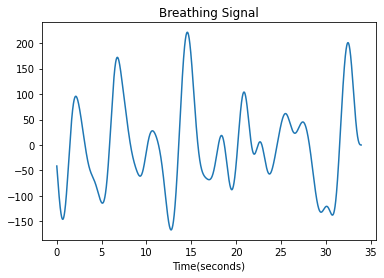

In [12]:
# Plot breathing signal derived from PPG signal
x_axis_br = [i/1000.0 for i in range(len(wd['breathing_signal']))]
plt.plot(x_axis_br, wd['breathing_signal'])
plt.xlabel('Time(seconds)')
plt.title('Breathing Signal')